## PLAsTiCC supernova classification - CNN approach

- In this notebook i try to classify supernova stars based on photometry recordings as shared with [PLAsTiCC dataset](https://plasticc.org) released together with this [kaggle competition](https://www.kaggle.com/c/PLAsTiCC-2018).
- The dataset has been syntheticaly created in order to help astronomers prepare for new [Large Synoptic Survey Telescope](https://lsst-tvssc.github.io/) which is about to revolutionazie the field.
- Most of the kernels shared on Kaggle ([including the winner](https://www.kaggle.com/c/PLAsTiCC-2018/discussion/75033))
used some type of feature extraction process (e.g. modeling with gausian processes) and then ensemble models like LightGBM and different blends (like [here](https://www.kaggle.com/c/PLAsTiCC-2018/discussion/75012) or [here](https://www.kaggle.com/c/PLAsTiCC-2018/discussion/75050)). There were some trials on raw data modeling mostly using some form of RNNs.
- In this notebook i want to try an **alternative solution: single functional Keras model combining raw flux inputs (light curve magnitudes on 6 passbands) with metadata and some basic extracted features. Raw flux inputs are reshaped into an array with errors as channels and 6 different passbands as the width of the array. As a results 2D CNN can be used.**
- There are two key ingredients that seems to be crucial for high score on this dataset: 1. Data augmentation (original test set is very different from the training set, general quality of measurement is worst so some form of degradation is needed) 2. Predicting "Unknown" objects - class 99 for wich we do not have labeled training set. Both problems have been ommited in this notebook.

_____

### SETUP

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [179]:
import os
import gc
import itertools
from datetime import date, datetime
import glob
import random
import pdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import tensorflow as tf
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras import optimizers, callbacks
from tensorflow.python.keras.models import *
from tensorflow.python.keras.layers import *
from keras.utils.vis_utils import plot_model

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,  confusion_matrix
from sklearn.model_selection import train_test_split

from multiprocessing import Pool
from numba import jit
import h5py
from astropy.table import Table
from astropy.time import Time
from tsfresh.feature_extraction import extract_features
import tsfresh
import feets

In [6]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.list_devices()

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 2928760380853289520),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 16114556978795669666),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 9287609553933352383),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 7931884340, 11156984987772858282)]

____

### HELPERS

In [7]:
def make_lcarr(object_id):
    '''Extracts and reshapes light curve values into (6, 72, 2) format: passbands x length, errors->channels'''
    lc = df[df['object_id'] == object_id].groupby(['passband']).apply(np.array).values
    lo = []
    for i in range(6):
        p1 = lc[i][:,[2,3]] # flux, err columns
        p2 = np.zeros(shape=(72, 2))
        p2[:p1.shape[0],:p1.shape[1]] = p1
        lo.append(p2)
    return np.asarray(lo)

In [185]:
def show_flux(array, ind=0):
    plt.ylabel("channel")
    plt.imshow(array[ind][0:6,0:72,0])

    
def show_imgs(array, n=30):
    plt.figure(figsize=(14, 6))
    for i in range(n):
        plt.gray()
        ax = plt.subplot(n/3, 3, i+1)
        show_flux(array, ind=i)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

def plot_training(history):
    print(f"Max val accuracy: {np.max(history.history['val_main_output_acc'])}")
    print(f"Min val loss: {np.min(history.history['val_main_output_loss'])}")
    #print(history.history.keys())
    
    # summarize history for accuracy
    #plt.subplot(1, 2, 1)
    plt.plot(history.history['main_output_acc'])
    plt.plot(history.history['val_main_output_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    # plt.subplot(1, 2, 2)
    plt.plot(history.history['main_output_loss'])
    plt.plot(history.history['val_main_output_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

#https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.plot()    

____

### LOAD DATA

In [124]:
tr = pd.read_csv("../input/training_set.csv")
tr_meta = pd.read_csv("../input/training_set_metadata.csv")

assert(tr['object_id'].unique().tolist() == tr_meta['object_id'].unique().tolist())

**Shuffle**

In [125]:
objects_list = tr_meta['object_id'].unique().tolist()
random.shuffle(objects_list)
tr.set_index('object_id', inplace=True); tr_meta.set_index('object_id', inplace=True)
tr = tr.loc[objects_list]
tr_meta = tr_meta.loc[objects_list]
tr.reset_index(inplace=True); tr_meta.reset_index(inplace=True)
assert(tr['object_id'].unique().tolist() == tr_meta['object_id'].unique().tolist())

**Single record**

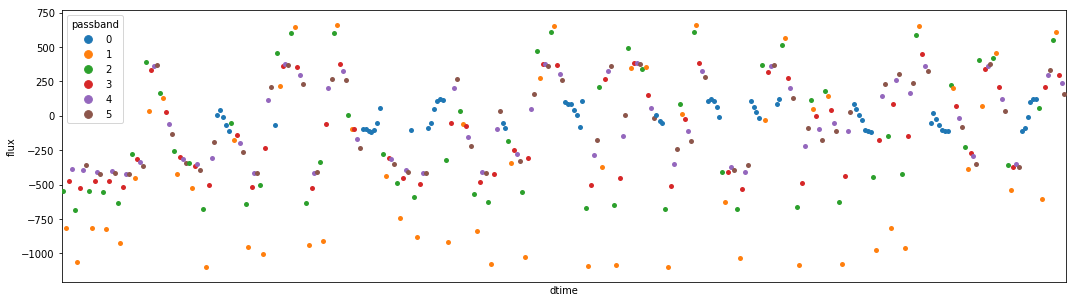

In [127]:
o1 = tr[tr['object_id'] == 615]
o1['dtime'] = Time(o1['mjd'], format='mjd').datetime
o1['passband'] = o1['passband'].apply(str)
fig, ax = plt.subplots(figsize=(18,5))
sns.stripplot(x='dtime', y='flux', data=o1, hue='passband')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.show()

### PREP TARGETS

In [128]:
y = tr_meta['target'].astype(str).tolist()
classes = sorted(set(y))
class_names = list(sample_sub.columns[1:-1])

print(f'Unique classes : {classes}')
print(f'Classes names: {class_names}') # missing class 99

Unique classes : ['15', '16', '42', '52', '53', '6', '62', '64', '65', '67', '88', '90', '92', '95']
Classes names: ['class_6', 'class_15', 'class_16', 'class_42', 'class_52', 'class_53', 'class_62', 'class_64', 'class_65', 'class_67', 'class_88', 'class_90', 'class_92', 'class_95']


In [129]:
y_idx = [classes.index(y_i) for y_i in y]
y_cat = to_categorical(y_idx)
y_cat[0:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]],
      dtype=float32)

### MAKE FLUX AND ERROR INPUTS

In [131]:
# making grouped normalization faster with broadcasting:
# https://stackoverflow.com/questions/26046208/normalize-dataframe-by-group
def normalize_by_group(df, by):
    groups = df.groupby(by)
    mean = groups.transform(np.mean)
    std = groups.transform(np.std)
    return (df[mean.columns] - mean) / std

In [132]:
%%time
# normalize flux and flux_err by star (loosing overall flux level)
df = tr[['object_id', 'passband', 'flux', 'flux_err']]
df.loc[:,['flux', 'flux_err']] = normalize_by_group(df, ['object_id', 'passband'])
df.fillna(0, inplace=True)

# multiprocess make array
objects_list = df['object_id'].unique().tolist()
pool = Pool(8)
result = pool.map(make_lcarr, objects_list)
pool.close()
X = np.stack(result)

print(X.shape)

(7848, 6, 72, 2)
CPU times: user 1.98 s, sys: 2.94 s, total: 4.91 s
Wall time: 7.45 s


**Photometry data reshaped into 2D image-like format:**

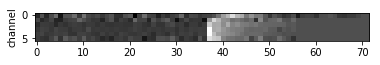

In [160]:
show_flux(X, 9)

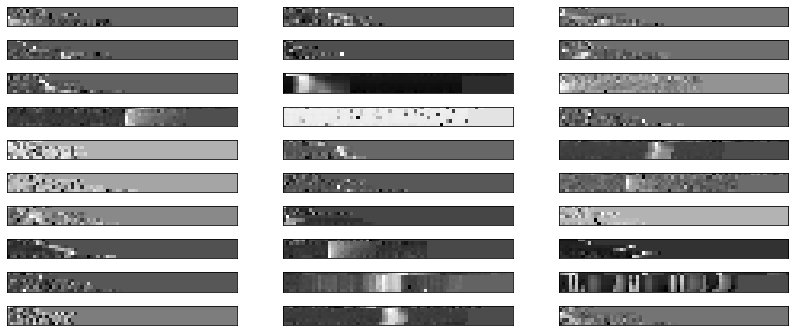

In [134]:
show_imgs(X, 30)

In [135]:
print("X shape:{}".format(X.shape), "y_cat shape:{}".format(y_cat.shape))

X shape:(7848, 6, 72, 2) y_cat shape:(7848, 14)


- visible edges corresponding to rapid as well as gradients with different intensities for different channels
- since sequences have different lengths, I pad them and fill missing data with zeros (since data are scaled and centered, 0 correspond to the mean of registered data for a given star)
- aligning is problematic and CNN can help with that if missalignments between channels are non random (based on the description provided by organizers they are not)

### SOME FEATURE EXTRACTION

In [136]:
%%time
gc.enable()

train = tr
train['flux_ratio_sq'] = np.power(train['flux'] / train['flux_err'], 2.0)
train['flux_by_flux_ratio_sq'] = train['flux'] * train['flux_ratio_sq']

aggs = {
    'mjd': ['min', 'max'],
    'flux': ['min', 'max', 'mean', 'median', 'std','skew'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std','skew'],
    'detected': ['mean'],
    'flux_ratio_sq':['sum','skew'],
    'flux_by_flux_ratio_sq':['sum','skew'],
}

fcp = {
    'kurtosis' : None,
    'skewness' : None,
    'count_above_mean' : None,
    'longest_strike_above_mean' : None,
    'number_peaks' : [{'n' : 2}],
    'abs_energy': None,
    'sample_entropy' : None,
    'absolute_sum_of_changes' : None,
    'cid_ce' : [{'normalize' : True}],
    'fft_coefficient': [{'coeff': 0, 'attr': 'abs'}, {'coeff': 1, 'attr': 'abs'}]
}

agg_train = train.groupby('object_id').agg(aggs)
new_columns = [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]
agg_train.columns = new_columns
agg_train['mjd_diff'] = agg_train['mjd_max'] - agg_train['mjd_min']
agg_train['flux_diff'] = agg_train['flux_max'] - agg_train['flux_min']
agg_train['flux_dif2'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_mean']
agg_train['flux_w_mean'] = agg_train['flux_by_flux_ratio_sq_sum'] / agg_train['flux_ratio_sq_sum']
agg_train['flux_dif3'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_w_mean']
del agg_train['mjd_max'], agg_train['mjd_min']

# Add more features with tsfresh
agg_df_ts = extract_features(train, column_id='object_id',
                             column_sort='mjd',
                             column_kind='passband',
                             column_value = 'flux',
                             default_fc_parameters = fcp,
                             n_jobs=8)
df_det = train[train['detected']==1].copy()

agg_df_mjd = extract_features(df_det,
                              column_id='object_id',
                              column_value = 'mjd',
                              default_fc_parameters = {'maximum':None, 'minimum':None},
                              n_jobs=8)

agg_df_mjd['mjd_diff_det'] = agg_df_mjd['mjd__maximum'] - agg_df_mjd['mjd__minimum']
del agg_df_mjd['mjd__maximum'], agg_df_mjd['mjd__minimum']
agg_df_ts = pd.merge(agg_df_ts, agg_df_mjd, on = 'id')

# tsfresh returns a dataframe with an index name='id'
agg_df_ts.index.rename('object_id',inplace=True)
agg_train = pd.merge(agg_train, agg_df_ts, on='object_id')

del train
gc.collect()

Feature Extraction: 100%|██████████| 40/40 [00:00<00:00, 51.90it/s]


CPU times: user 25.5 s, sys: 10.1 s, total: 35.6 s
Wall time: 38.4 s


In [138]:
agg_train.reset_index(inplace=True)
agg_train.head()

,index,object_id,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_skew,flux_err_min,flux_err_max,...,5__cid_ce__normalize_True,5__count_above_mean,"5__fft_coefficient__coeff_0__attr_""abs""","5__fft_coefficient__coeff_1__attr_""abs""",5__kurtosis,5__longest_strike_above_mean,5__number_peaks__n_2,5__sample_entropy,5__skewness,mjd_diff_det
0,0,615,-1100.440063,660.626343,-123.096998,-89.477524,394.109851,-0.349540,2.130510,12.845472,...,9.550230,27.0,2704.641265,2893.344217,-1.592820,5.0,11.0,1.886318,0.125268,873.7903
1,1,713,-14.735178,14.770886,-1.423351,-0.873033,6.471144,0.014989,0.639458,9.115748,...,7.607781,26.0,100.473776,143.963093,-0.797047,8.0,9.0,2.302585,0.218182,846.8017
2,2,730,-19.159811,47.310059,2.267434,0.409172,8.022239,3.177854,0.695106,11.281384,...,6.403841,19.0,231.509177,199.286370,3.583130,7.0,8.0,1.813163,1.680352,78.7737
3,3,745,-15.494463,220.795212,8.909206,1.035895,27.558208,4.979826,0.567170,55.892746,...,6.637178,15.0,591.037583,523.503586,12.134629,10.0,11.0,1.321756,3.170857,123.6872
4,4,1124,-16.543753,143.600189,7.145702,1.141288,20.051722,4.406298,0.695277,11.383690,...,6.630402,13.0,393.114268,357.907185,14.434470,6.0,9.0,1.231070,3.657305,133.9113


____

### MAKE META DATA INPUTS

In [139]:
x_meta = tr_meta
x_meta = x_meta.merge(right=agg_train, how='left', on='object_id')
x_meta = x_meta.drop(['object_id', 'target', 'distmod', 'hostgal_photoz'], axis=1)
x_meta.replace([np.inf, -np.inf], np.nan, inplace=True)
x_meta.fillna(0, inplace=True)

In [140]:
x_meta.head()

,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz_err,mwebv,index,flux_min,...,5__cid_ce__normalize_True,5__count_above_mean,"5__fft_coefficient__coeff_0__attr_""abs""","5__fft_coefficient__coeff_1__attr_""abs""",5__kurtosis,5__longest_strike_above_mean,5__number_peaks__n_2,5__sample_entropy,5__skewness,mjd_diff_det
0,187.734375,-33.331287,298.020068,29.344867,0,2.0746,0.2232,0.072,6026,-75.885254,...,6.796953,15.0,450.122804,579.229447,0.399624,10.0,5.0,2.186586,0.116509,19.0174
1,18.281250,-34.409527,271.674092,-81.359695,0,0.2335,0.0118,0.017,4758,-36.408535,...,7.244253,12.0,571.067473,229.880410,0.245044,4.0,5.0,2.063441,0.717567,31.9866
2,185.097656,-14.477512,291.724247,47.717463,0,0.3652,0.0142,0.046,6631,-82.923943,...,7.566211,15.0,293.737941,428.584933,1.573874,6.0,5.0,2.094709,-0.190005,39.8510
3,152.402344,-3.583322,244.755230,40.342970,0,0.2436,0.4242,0.026,6862,-59.913097,...,6.351670,9.0,439.255003,431.597955,4.318127,3.0,6.0,1.550597,1.999423,214.3488
4,180.000000,3.433834,273.292126,63.306186,0,0.4076,0.0370,0.021,6965,-53.988014,...,5.335306,6.0,27.984200,106.358564,-1.120356,3.0,1.0,2.908721,0.104259,442.7786


** Split and scale **

In [142]:
x_train, x_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=123)
x_meta_train, x_meta_test, y_train, y_test = train_test_split(x_meta, y_cat, test_size=0.2, random_state=123)

In [143]:
scaler = StandardScaler()
x_meta_train[list(x_meta_train.columns)] = scaler.fit_transform(x_meta_train[list(x_meta_train.columns)])
x_meta_test[list(x_meta_test.columns)] = scaler.transform(x_meta_test[list(x_meta_test.columns)])
x_meta_train = np.array(x_meta_train)
x_meta_test = np.array(x_meta_test)

____

### MODEL

In [144]:
myadam = optimizers.adam(lr=0.01)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.0005)

In [149]:
flux_input = Input(shape=(6, 72, 2), name='main_input')
x = Conv2D(250, kernel_size=(3, 3), activation='relu', name='conv1')(flux_input)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
x = GlobalAvgPool2D()(x) #!!!
x = Dense(150, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
auxiliary_output = Dense(len(classes), activation='softmax', name='aux_output')(x)
meta_input = Input(shape=(98,), name='meta_input')
x = concatenate([x, meta_input])
x = Dense(150, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
main_output = Dense(len(classes), activation='softmax', name='main_output')(x)

model = Model(inputs=[flux_input, meta_input], outputs=[main_output, auxiliary_output])
#model.compile(optimizer='adam', loss=mywloss, metrics=['accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.summary()

- Stage 1: raw flux data from 6 passbands together with errors are passed through 2D conv layer, summarized with global average pooling and passed through one fully connected layer
- Stage 2: the output is concatenated with meta features and together passed through two more fully connected layers
- Dropout and batchnormalization are added between all steps

In [187]:
plot_model(model, to_file='../media/cnn_plus.png', show_shapes=True, show_layer_names=True)

<center><img width = 650 src="../media/cnn_plus.png"></img></center>

____

### TRAINING

In [151]:
%%time
history = model.fit([x_train, x_meta_train], [y_train, y_train],
                    validation_data=([x_test, x_meta_test], [y_test, y_test]),
                    epochs=300,
                    batch_size=128,
                    shuffle=True,
                    verbose=False) 

CPU times: user 5min 26s, sys: 1min 1s, total: 6min 28s
Wall time: 4min 53s


Max val accuracy: 0.7961783435693972
Min val loss: 0.6308446193956265


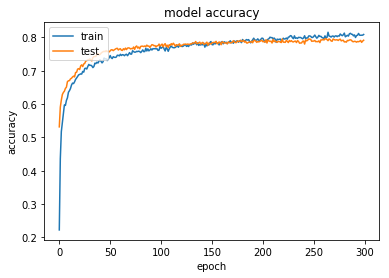

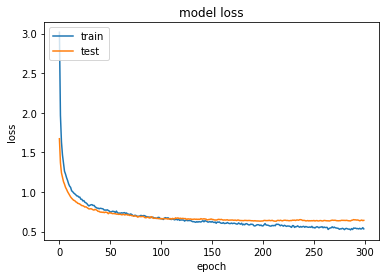

In [161]:
plot_training(history)

In [ ]:
model_name = "fun_cnn_72days_err_2_300"
model.save(f'../models/{model_name}.h5')

### RESULTS

In [174]:
preds = model.predict([x_test, x_meta_test])[0]
y_pred_idx = np.argmax(preds, axis=1).tolist()
y_pred_name = [class_names[idx] for idx in y_pred_idx]
y_true_idx = np.argmax(y_test, axis=1).tolist()
y_true_name = [class_names[idx] for idx in y_true_idx]

In [176]:
print(classification_report(y_true_name, y_pred_name))

             precision    recall  f1-score   support

   class_15       0.96      1.00      0.98       161
   class_16       0.66      0.64      0.65       254
   class_42       0.33      0.03      0.05        38
   class_52       1.00      0.40      0.57         5
   class_53       0.95      0.70      0.81        27
    class_6       0.67      0.63      0.65        87
   class_62       0.48      0.36      0.41       101
   class_64       0.87      0.52      0.65        25
   class_65       0.95      0.99      0.97       195
   class_67       0.71      0.21      0.33        47
   class_88       0.96      1.00      0.98        70
   class_90       0.75      0.92      0.82       464
   class_92       0.98      0.98      0.98        54
   class_95       0.95      0.93      0.94        42

avg / total       0.78      0.79      0.77      1570



With such a small sample and unbalanced dataset some classes are almost absent in the validation set.

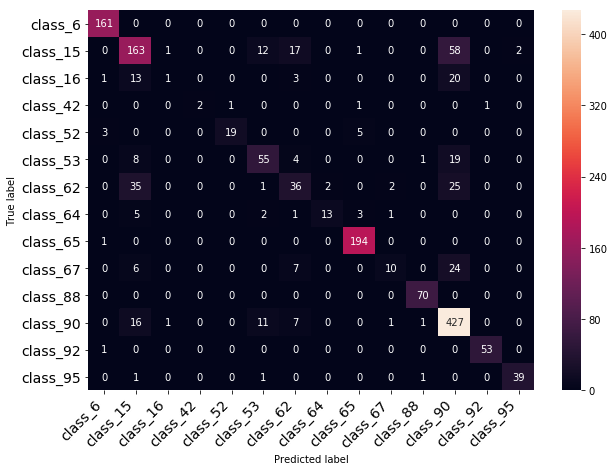

In [186]:
cm = confusion_matrix(y_true_name, y_pred_name)
print_confusion_matrix(cm, class_names)

Some of the classes are very easy to pick up with this approach (90!) while others, especially the ones with only few examples, are easily confused with bigger groups (62?). Some form of weightining for loss would be needed depending on class importance.